### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Activation functions

In [2]:
# Symmetric binary step
def binaryStep(n):
    return 1 if n>=0 else -1

In [3]:
# linear
def pureLin(n):
    return n

In [4]:
# Positive Linear
def posLin(n):
    return 0 if n < 0 else n

In [5]:
# Symmetric saturating linear
def satLin(n):
    if (n < -1):
        return -1
    elif (n > 1):
        return 1
    else:
        return n

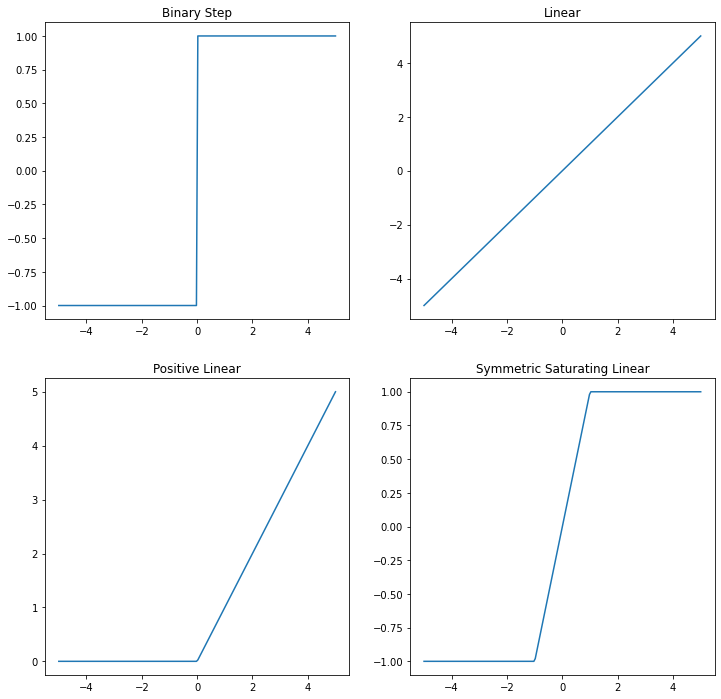

In [136]:
# visualise functions
x = np.linspace(start=-5, stop=5, num=200)


plt.figure(figsize=(12, 12))

# Binary Step
y = np.array([binaryStep(xi) for xi in x]) 
plt.subplot(2, 2, 1)
plt.plot(x, y)
plt.gca().set_title("Binary Step")

# Linear
y = np.array([pureLin(xi) for xi in x]) 
plt.subplot(2, 2, 2)
plt.plot(x, y)
plt.gca().set_title("Linear")

# Positive linear
y = np.array([posLin(xi) for xi in x]) 
plt.subplot(2, 2, 3)
plt.plot(x, y)
plt.gca().set_title("Positive Linear")

# Symmetric saturating linear
y = np.array([satLin(xi) for xi in x]) 
plt.subplot(2, 2, 4)
plt.plot(x, y)
plt.gca().set_title("Symmetric Saturating Linear")
plt.show()

### Three-input perceptron example

In [7]:
class ThreeInputPerceptron():
    def __init__(self, f):
        self.weights = np.array([0, 1, 0])
        self.bias = 0
        self.f = f
        
    def feedForward(self, x):
        self.netinput = np.dot(x, self.weights) + self.bias
        self.activation = self.f(self.netinput)

In [8]:
# test
# where input represents [roundness, smoothness, weight] (weight less than or greater than one pound)
# e.g. orange = [round=1, smoothness=-1, weight=-1]
#
# Output = 1 for apple
# Output = -1 for orange 

# Define perceptron with binary step activation function
perceptron = ThreeInputPerceptron(binaryStep)

# "perfect" apple (round, smooth, < 1lb)
xapple = np.array([1, 1, -1])

# "perfect" orange (round, rough, < 1lb)
xorange = np.array([1, -1, -1])

# imperfect orange (elliptical, rough, <1lb)
xorange2 = np.array([-1, -1, -1])

# imperfect apple (elliptical, smooth, <1lb)
xapple2 = np.array([-1, 1, -1])



print('"Perfect" fruit tests:')
perceptron.feedForward(xapple)
print("xapple = " + str(perceptron.activation) + " (= apple)")

perceptron.feedForward(xorange)
print("xorange = " + str(perceptron.activation) + " (= orange)")

print('\n "Imperfect" fruit tests:')
perceptron.feedForward(xapple2)
print("xapple2 = " + str(perceptron.activation) + " (= apple)")

perceptron.feedForward(xorange2)
print("xorange2 = " + str(perceptron.activation) + " (= orange)")

"Perfect" fruit tests:
xapple = 1 (= apple)
xorange = -1 (= orange)

 "Imperfect" fruit tests:
xapple2 = 1 (= apple)
xorange2 = -1 (= orange)


### Hamming Network example

In [74]:
class SimpleHamming():
    def __init__(self, f1, f2, protoPatterns):
        # network parameters
        self.ffweights = np.array(list(protoPatterns.values()))
        self.ffbias = np.full((len(protoPatterns), 1), np.size(self.ffweights, 1))
        #np.array([[3.0],[3.0]])
        self.rlweights = np.array([[1.0, -0.5],[-0.5, 1.0]])
        self.f1 = f1
        self.f2 = f2
        # output
        self.classes = np.array(list(protoPatterns.keys()))
        

    def feedForward(self):
        self.net1 = np.dot(self.ffweights, self.input) + self.ffbias
        self.a1 = np.array([self.f1(ai) for ai in self.net1]) 

    def recurApply(self, a2t):
        net2 = np.dot(self.rlweights, a2t)
        out = np.zeros((2,1))
        for n, x in np.ndenumerate(net2):
            out[n] = self.f2(x)
        return out

    def recurrentLayer(self, a2_0):
        a2t = a2_0
        a2tp1 = self.recurApply(a2t)
        if (a2t == a2tp1).all():
            return a2tp1
        else: 
            return self.recurrentLayer(a2tp1)
        
    def readableOutput(self):
        if (self.output[0] != 0):
            print("By jove, that's an " + self.classes[0] + "!")
        else:
            print("Ermagerhd, it's an " + self.classes[1] + "!")
        
    def runNetwork(self, x):
        self.input = x
        self.feedForward()
        self.output = self.recurrentLayer(self.a1)   
        self.readableOutput()

In [75]:
protoPatterns = {"orange": [1, -1, -1],
                 "apple": [1, 1, -1]}

hamming = SimpleHamming(pureLin, posLin, protoPatterns)

# perfect apple
x = np.array([[1.0], [1.0], [-1.0]])
hamming.runNetwork(x)
print("\n")

# perfect orange
x2 = np.array([[1.0], [-1.0], [-1.0]])
hamming.runNetwork(x2)
print("\n")

# imperfect apple
x3 = np.array([[-1.0], [1.0], [-1.0]])
hamming.runNetwork(x3)
print("\n")

# imperfect orange
x4 = np.array([[-1.0], [-1.0], [-1.0]])
hamming.runNetwork(x4)

Ermagerhd, it's an apple!


By jove, that's an orange!


Ermagerhd, it's an apple!


By jove, that's an orange!


### Hopfield Network example

In [125]:
class SimpleHopfield():
    def __init__(self, protoPatterns, f):
        # Parameters
        self.weights = np.array([[0.2, 0.0, 0.0], [0.0, 1.2, 0.0], [0.0, 0.0, 0.2]])
        self.bias = np.array([0.9, 0.0, -0.9]).reshape(3, 1)
        self.f = f
        
        # Extras
        self.classes = protoPatterns
        
    def layerApply(self, layerIn):
        net = np.dot(self.weights, layerIn) + self.bias
        out = np.zeros((3, 1))
        for n, x in np.ndenumerate(net):
            out[n] = self.f(x)
        return out
            
    def recurrentLayer(self, a0):
        atp1 = self.layerApply(a0)
        if (a0 == atp1).all():
            return atp1
        else: 
            return self.recurrentLayer(atp1)   
        
    def makeOutput(self, output):
        for key, value in self.classes.items():
            if (output == value).all():
                return key
        return "error"
    
        #print(list(self.classes.keys())[list(self.classes.values()).index(output)])
            
    def runNetwork(self, x):
        self.input = x
        self.output = self.recurrentLayer(x)   
        print("Ah geeze, it's an " + self.makeOutput(self.output) + "!")

In [126]:
# Testing

protoPatterns = {"orange": [[1.0], [-1.0], [-1.0]],
                 "apple": [[1.0], [1.0], [-1.0]]}

hopfield = SimpleHopfield(protoPatterns, satLin)

# perfect apple
x = np.array([[1.0], [1.0], [-1.0]])
hopfield.runNetwork(x)
print("\n")

# perfect orange
x2 = np.array([[1.0], [-1.0], [-1.0]])
hopfield.runNetwork(x2)
print("\n")

# imperfect apple
x3 = np.array([[-1.0], [1.0], [-1.0]])
hopfield.runNetwork(x3)
print("\n")

# imperfect orange
x4 = np.array([[-1.0], [-1.0], [-1.0]])
hopfield.runNetwork(x4)

Ah geeze, it's an apple!


Ah geeze, it's an orange!


Ah geeze, it's an apple!


Ah geeze, it's an orange!
